In [16]:
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt


In [14]:
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

In [2]:
csv_dir = '/ccn2/u/khaiaw/Code/babyview-pose/object-detection/video-qa/vis_model_predictions/unconstrained_activities'
csv_files = [f for f in os.listdir(csv_dir) if f.endswith('.csv')]
print(f'Found {len(csv_files)} CSV files in {csv_dir}')

Found 5711 CSV files in /ccn2/u/khaiaw/Code/babyview-pose/object-detection/video-qa/vis_model_predictions/unconstrained_activities


In [7]:
# There are two columns I care about: Location, Activity
# Concatenate all CSV files into two series for these
location_series = pd.Series(dtype='object')
activity_series = pd.Series(dtype='object')
for csv_file in tqdm(csv_files, desc="Processing CSV files"):
    file_path = os.path.join(csv_dir, csv_file)
    df = pd.read_csv(file_path)
    if 'Location' in df.columns and 'Activity' in df.columns:
        location_series = pd.concat([location_series, df['Location']], ignore_index=True)
        activity_series = pd.concat([activity_series, df['Activity']], ignore_index=True)
print(f'Concatenated {len(location_series)} Location entries and {len(activity_series)} Activity entries.')

Processing CSV files:   0%|          | 0/5711 [00:00<?, ?it/s]

Processing CSV files: 100%|██████████| 5711/5711 [00:20<00:00, 281.56it/s]

Concatenated 106970 Location entries and 106970 Activity entries.


## Locations

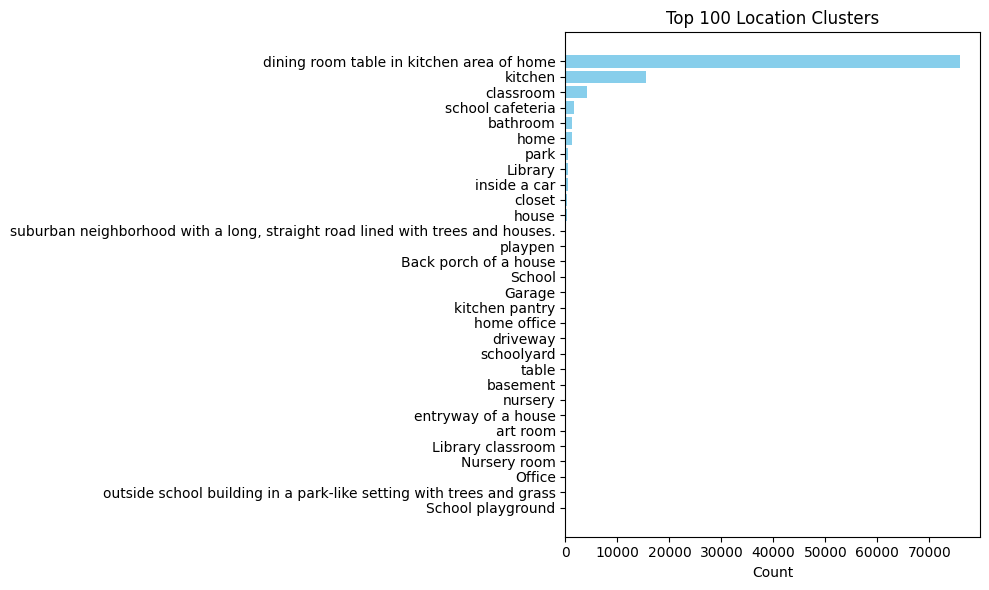

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd

model = SentenceTransformer('all-MiniLM-L6-v2')   # ≈22 MB
unique_locations = location_series.unique()              # de-dupe first for speed
emb = model.encode(unique_locations,
                   normalize_embeddings=True,
                   show_progress_bar=True)

# cosine distance → smaller eps → stricter grouping
cl = DBSCAN(eps=0.15, min_samples=1, metric='cosine').fit(emb)
labels = cl.labels_

# map each cluster to a representative phrase + total count
label_to_rep = {}
counts = {}
for lbl, phrase in zip(labels, unique_locations):
    # representative = first phrase we see in that cluster
    label_to_rep.setdefault(lbl, phrase)
    counts[label_to_rep[lbl]] = counts.get(label_to_rep[lbl], 0) + (location_series == phrase).sum()

top_location_clusters = (pd.Series(counts)
           .sort_values(ascending=False)
           .head(100)
           .rename_axis('location')
           .reset_index(name='count'))

top_location_clusters.to_csv(os.path.join(output_dir, 'top_location_clusters.csv'), index=False)

# Plot just the top N
top_location_clusters = top_location_clusters.head(30)

plt.figure(figsize=(10, 6))
plt.barh(top_location_clusters['location'], top_location_clusters['count'], color='skyblue')
plt.xlabel('Count')
plt.title('Top 100 Location Clusters')
plt.gca().invert_yaxis()  # reverse y-axis to have the highest count on top
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'top_location_clusters.png'))

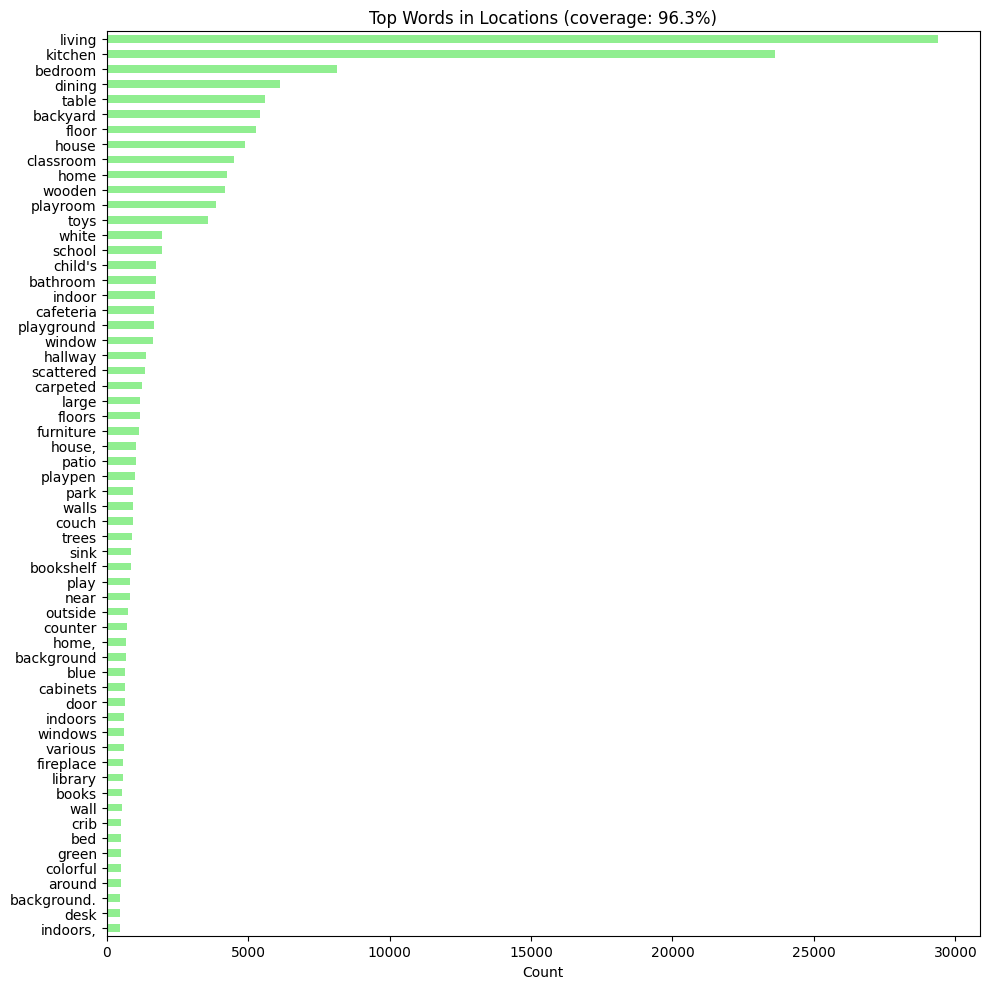

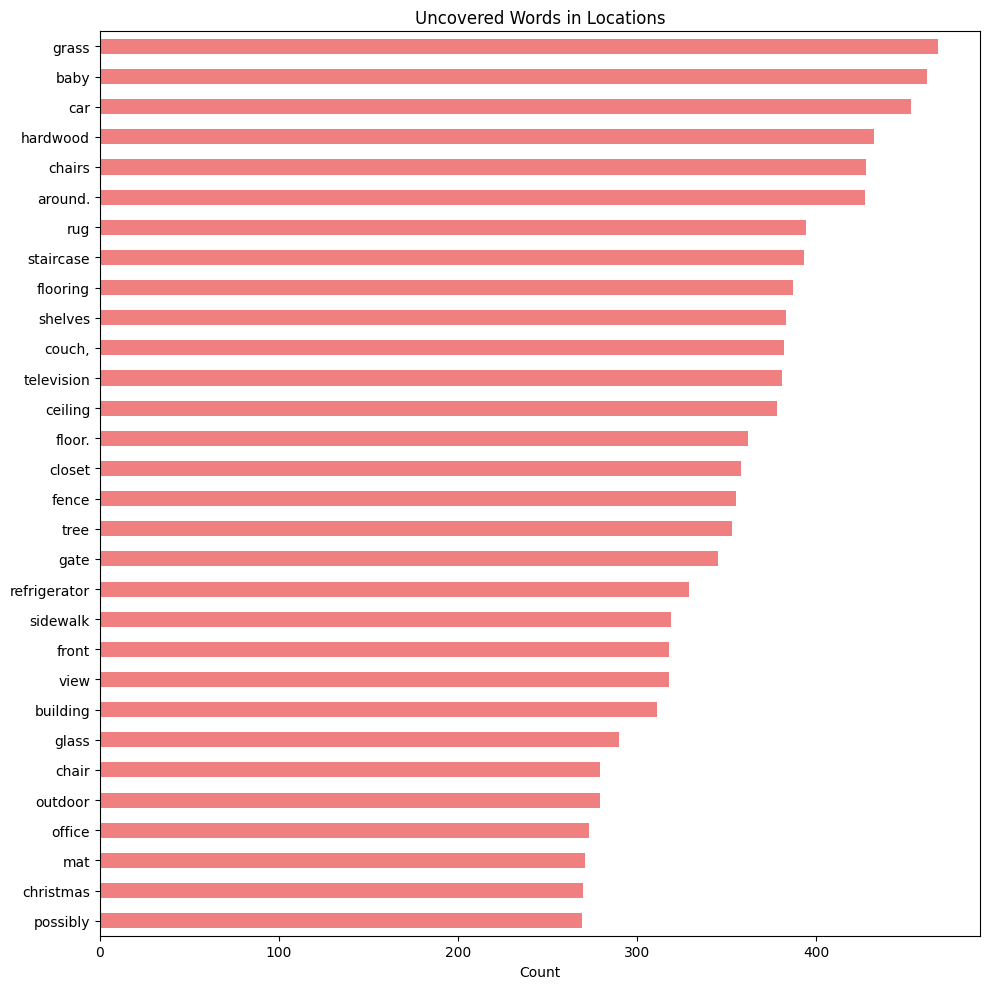

In [48]:
# just concatenate all the words in location_series, and then plot a word count bar plot
from collections import Counter

exclude_words = ['room', 'a', 'with', 'the', 'inside', 'area', 'and', 'of', 'in', 'at', 'on', 'to', 'for', 'is', 'an', 'by', 'from', 'this', 'that', 'it', 'as', 'or']

word_counts = Counter(word.lower() for word in ' '.join(location_series).split() if word.lower() not in exclude_words)
top_words = pd.Series(word_counts).sort_values(ascending=False).head(60)

# figure out how many % of all entries location_series contain at least one of these words
total_entries = len(location_series)
total_entries_covered_by_top_words = sum(location_series.str.contains('|'.join(top_words.index), case=False, na=False))
coverage_percentage = total_entries_covered_by_top_words / total_entries * 100
coverage_percentage = round(coverage_percentage, 1)

plt.figure(figsize=(10, 10))
top_words.plot(kind='barh', color='lightgreen')
plt.xlabel('Count')
plt.title('Top Words in Locations (coverage: {:.1f}%)'.format(coverage_percentage))
plt.gca().invert_yaxis()  # reverse y-axis to have the highest count on top
plt.tight_layout()

# plot the words that are not covered by the top words
uncovered_words = [word for word in word_counts if word not in top_words.index]
uncovered_word_counts = pd.Series({word: count for word, count in word_counts.items() if word in uncovered_words})
uncovered_word_counts = uncovered_word_counts.sort_values(ascending=False).head(30)
plt.figure(figsize=(10, 10))
uncovered_word_counts.plot(kind='barh', color='lightcoral')
plt.xlabel('Count')
plt.title('Uncovered Words in Locations')
plt.gca().invert_yaxis()  # reverse y-axis to have the highest count on top
plt.tight_layout()

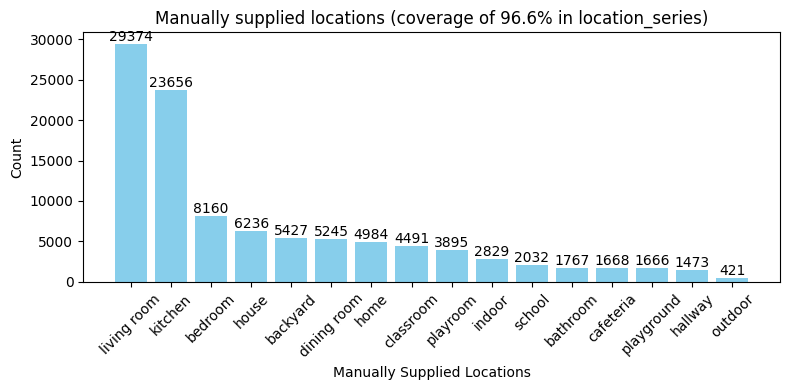

In [56]:
manual_location_list = ['living room', 'kitchen', 'bedroom', 'dining room', 'backyard', 'bathroom', 'indoor', 'outdoor', 'school', 'classroom', 'cafeteria', 'playground', 'hallway', 'house', 'home', 'playroom']

# For each manual location in manual_location_list, calculate the count of entries in location_series that contain it (case-insensitive)
counts_manual = {}
for loc in manual_location_list:
    counts_manual[loc] = location_series.str.lower().str.contains(loc.lower()).sum()
counts_manual = dict(sorted(counts_manual.items(), key=lambda item: item[1], reverse=True))

# plot how many % of all locations are in the manual list
manual_count = sum(counts_manual.values())
total_count = len(location_series)
manual_percentage = (manual_count / total_count) * 100
manual_percentage = round(manual_percentage, 1)


# Plot the counts for each manual location
plt.figure(figsize=(8, 4))
plt.bar(list(counts_manual.keys()), list(counts_manual.values()), color='skyblue')
plt.xlabel('Manually Supplied Locations')
plt.ylabel('Count')
plt.title(f'Manually supplied locations (coverage of {manual_percentage:.1f}% in location_series)')
plt.xticks(rotation=45)
for i, count in enumerate(counts_manual.values()):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.tight_layout()
plt.show()


# plot the 

## Activities

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

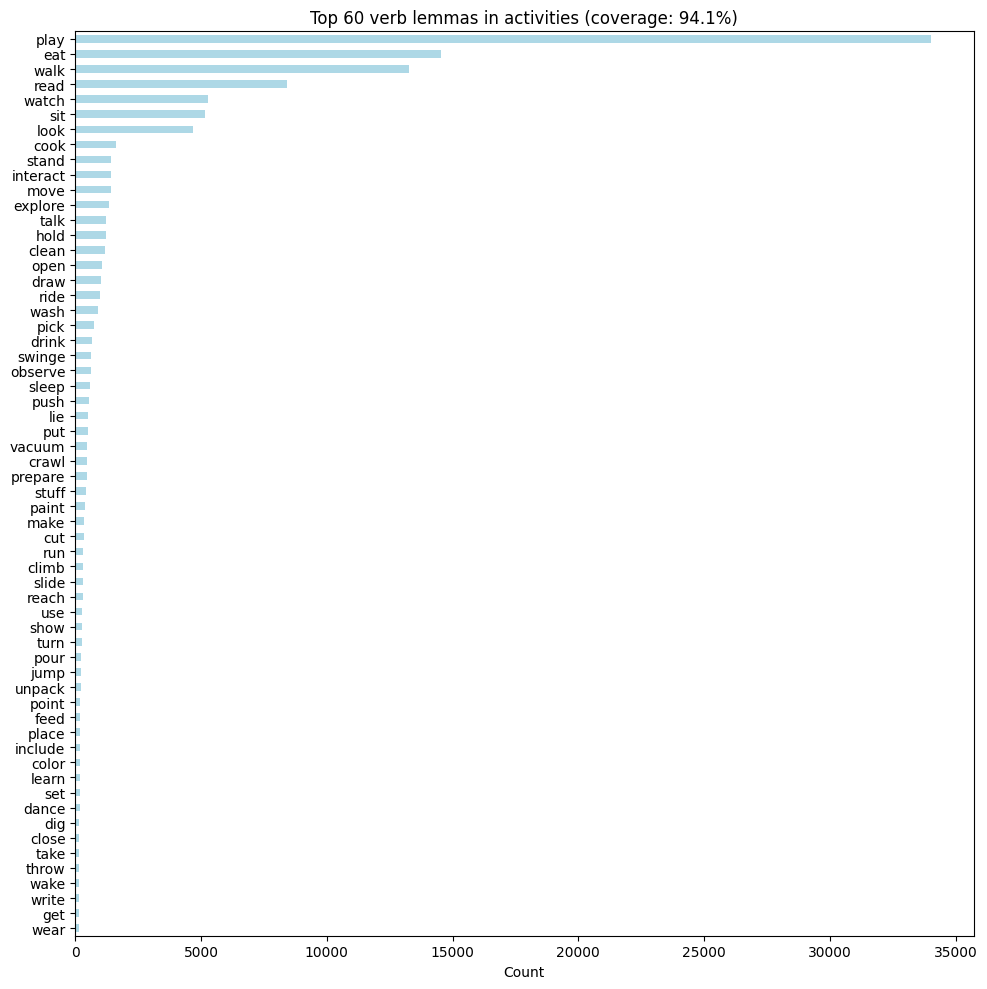

In [73]:
"""
- For each activity in activity_series:
- Identify all verb tokens, lemmatize them, and count their occurrences (across all activity entries).
- Plot top N verb lemmas in the activity_series, and how many % of all activities contain at least one of them
"""

import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import spacy

# — 1.  CONFIG --------------------------------------------------------------
activity_exclude_lemmas: set[str] = {"be"}  # verbs to ignore in counts / coverage
n_top_activity_lemmas: int = 60              # how many verbs to plot
batch_size: int = 1_000                      # spaCy pipe batch size

# spaCy pipeline: tokenizer + tagger + lemmatizer (NER / parser disabled for speed)
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

# — 2.  BUILD ACTIVITY LEMMA COUNTS ----------------------------------------
activity_lemma_counts: Counter[str] = Counter()

for doc in nlp.pipe(activity_series.astype(str).str.lower(),
                    batch_size=batch_size, n_process=-1):
    for tok in doc:
        if tok.pos_ == "VERB":
            lemma = tok.lemma_
            if lemma not in activity_exclude_lemmas:
                activity_lemma_counts[lemma] += 1

# Select top-N lemmas -------------------------------------------------------
_top = pd.Series(activity_lemma_counts).sort_values(ascending=False)
if len(_top) > n_top_activity_lemmas:
    top_activity_lemmas = _top.iloc[:n_top_activity_lemmas]
else:
    top_activity_lemmas = _top

top_lemma_set = set(top_activity_lemmas.index)

# — 3.  COVERAGE ------------------------------------------------------------
#   We determine coverage by re‑lemmatising each row and checking whether it
#   contains *any* of the top verb lemmas (so "playing" still counts for
#   the lemma "play").  This avoids false negatives that word‑boundary regexes
#   introduce when the surface form is inflected.

total_activity_rows = len(activity_series)
activity_rows_with_top = 0

for doc in nlp.pipe(activity_series.astype(str).str.lower(),
                    batch_size=batch_size, n_process=-1):
    if any(tok.lemma_ in top_lemma_set and tok.pos_ == "VERB" for tok in doc):
        activity_rows_with_top += 1

activity_coverage_pct = round(activity_rows_with_top / total_activity_rows * 100, 1)

# — 4.  PLOT ---------------------------------------------------------------
plt.figure(figsize=(10, 10))
(top_activity_lemmas.iloc[::-1]  # flip so largest bar is on top
                   .plot(kind="barh", color="lightblue"))
plt.xlabel("Count")
plt.title(f"Top {len(top_activity_lemmas)} verb lemmas in activities (coverage: {activity_coverage_pct}%)")
plt.tight_layout()
plt.show()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

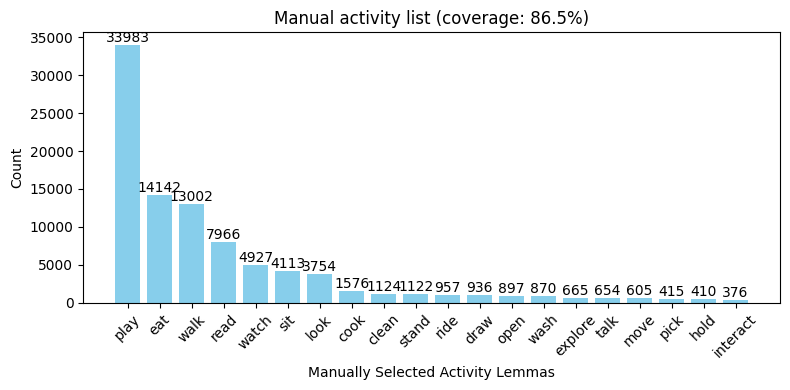

In [75]:
# — 6.  MANUAL ACTIVITY LIST COVERAGE -------------------------------------
# Use the same Series to construct a manual activity list (top 20 by default)
n_manual_activity: int = 20           # size of the manual activity list
manual_activity_list = list(top_activity_lemmas.index[:n_manual_activity])

# Initialise counts to zero
activity_counts_manual: dict[str, int] = {lemma: 0 for lemma in manual_activity_list}

for doc in nlp.pipe(activity_series.astype(str).str.lower(),
                    batch_size=batch_size, n_process=-1):
    # Gather lemmas present in this activity description
    lemmas_in_doc = {tok.lemma_ for tok in doc if tok.pos_ == "VERB"}
    for lemma in manual_activity_list:
        if lemma in lemmas_in_doc:
            activity_counts_manual[lemma] += 1
            break # so, even if an activity contains 2 lemmas, it only counts for the first one, no double-counting!

# Sort dict by frequency descending for nicer plotting
activity_counts_manual = dict(sorted(activity_counts_manual.items(),
                                     key=lambda item: item[1], reverse=True))

manual_activity_total = sum(activity_counts_manual.values())
manual_activity_pct = round(manual_activity_total / total_activity_rows * 100, 1)

# — 7.  PLOT MANUAL ACTIVITY COVERAGE --------------------------------------
plt.figure(figsize=(8, 4))
plt.bar(activity_counts_manual.keys(), activity_counts_manual.values(), color='skyblue')
plt.xlabel('Manually Selected Activity Lemmas')
plt.ylabel('Count')
plt.title(f'Manual activity list (coverage: {manual_activity_pct}%)')
plt.xticks(rotation=45)
for i, (lemma, count) in enumerate(activity_counts_manual.items()):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.tight_layout()
plt.show()